# CatBoost Classifier Baseline (Model Comparison) v3

- 모델 종류 체급 비교 목적

평가 (Test set):
- PR-AUC
- Recall (Churn)
- Accuracy
- Confusion Matrix
- Classification Report
- Feature Importance

In [5]:
import numpy as np
import pandas as pd

pd.set_option("display.max_columns", None)
pd.set_option('display.max_rows', None)


In [6]:
df = pd.read_parquet('../data/kkbox_train_feature_v3.parquet')


In [7]:
RANDOM_STATE = 719

ID_COL = "msno"
TARGET_COL = "is_churn"

CATEGORICAL_COLS = [
    "city", "gender", "registered_via", "last_payment_method",
    "has_ever_paid", "has_ever_cancelled",
    "is_auto_renew_last",
    "is_free_user",
]

NUMERICAL_COLS = [
    "reg_days",

    # ======================
    # w7
    # ======================
    "num_days_active_w7", "total_secs_w7", "avg_secs_per_day_w7", "std_secs_w7",
    "num_songs_w7", "avg_songs_per_day_w7", "num_unq_w7", "num_25_w7", "num_100_w7",
    "short_play_w7", "skip_ratio_w7", "completion_ratio_w7", "short_play_ratio_w7", "variety_ratio_w7",

    # ======================
    # w14
    # ======================
    "num_days_active_w14", "total_secs_w14", "avg_secs_per_day_w14", "std_secs_w14",
    "num_songs_w14", "avg_songs_per_day_w14", "num_unq_w14", "num_25_w14", "num_100_w14",
    "short_play_w14", "skip_ratio_w14", "completion_ratio_w14", "short_play_ratio_w14", "variety_ratio_w14",

    # ======================
    # w21
    # ======================
    "num_days_active_w21", "total_secs_w21", "avg_secs_per_day_w21", "std_secs_w21",
    "num_songs_w21", "avg_songs_per_day_w21", "num_unq_w21", "num_25_w21", "num_100_w21",
    "short_play_w21", "skip_ratio_w21", "completion_ratio_w21", "short_play_ratio_w21", "variety_ratio_w21",

    # ======================
    # w30  (OFF → 주석 처리)
    # ======================
    "num_days_active_w30", "total_secs_w30", "avg_secs_per_day_w30", "std_secs_w30",
    "num_songs_w30", "avg_songs_per_day_w30", "num_unq_w30", "num_25_w30", "num_100_w30",
    "short_play_w30", "skip_ratio_w30", "completion_ratio_w30", "short_play_ratio_w30", "variety_ratio_w30",

    # ======================
    # trend (주의: 상위 window에 종속됨)
    # ======================
    # w7–w14
    "days_trend_w7_w14",

    # w7–w30 / w14–w30 (w30 OFF 시 같이 OFF)
    "secs_trend_w7_w30", "secs_trend_w14_w30",
    "days_trend_w7_w30",
    "songs_trend_w7_w30", "songs_trend_w14_w30",
    "skip_trend_w7_w30", "completion_trend_w7_w30",

    # ======================
    # transactions (logs-only 실험 시 OFF)
    # ======================
    "days_since_last_payment", "days_since_last_cancel", "last_plan_days",
    "total_payment_count", "total_amount_paid", "avg_amount_per_payment",
    "unique_plan_count", "subscription_months_est",
    "payment_count_last_30d", "payment_count_last_90d",
]

FEATURE_COLS = CATEGORICAL_COLS + NUMERICAL_COLS

X = df[FEATURE_COLS].copy()
y = df[TARGET_COL].astype(int).copy()

## 1. Train / Test Split


In [8]:
from sklearn.model_selection import train_test_split

X = df[FEATURE_COLS]
y = df[TARGET_COL].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y,
)

print(X_train.shape, X_test.shape)


(688772, 83) (172194, 83)


## 2. Column Groups


In [9]:
cat_cols = [c for c in CATEGORICAL_COLS if c in X_train.columns]
num_cols = [c for c in NUMERICAL_COLS if c in X_train.columns]

print(f"num_cols: {len(num_cols)}")
print(f"cat_cols: {len(cat_cols)}")


num_cols: 75
cat_cols: 8


## 3. Preprocessing (CatBoost Native Categorical)


In [10]:
cat_feature_indices = [X_train.columns.get_loc(col) for col in cat_cols]

X_train_cb = X_train.copy()
X_test_cb = X_test.copy()

for col in cat_cols:
    X_train_cb[col] = X_train_cb[col].astype(str).astype("category")
    X_test_cb[col] = X_test_cb[col].astype(str).astype("category")


## 4. CatBoost Classifier Model


In [11]:
from catboost import CatBoostClassifier

cb_model = CatBoostClassifier(
    iterations=4000,
    learning_rate=0.03,
    depth=6,
    loss_function="Logloss",
    eval_metric="PRAUC",
    auto_class_weights="Balanced",
    random_seed=RANDOM_STATE,
    verbose=False,
    early_stopping_rounds=200,
)


## 5. Train Model


In [12]:
cb_model.fit(
    X_train_cb,
    y_train,
    eval_set=(X_test_cb, y_test),
    cat_features=cat_feature_indices,
    verbose=False,
)


## 6. Test Evaluation


In [44]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    average_precision_score,
    recall_score,
    accuracy_score,
    confusion_matrix,
    classification_report,
)


y_proba = cb_model.predict_proba(X_test_cb)[:, 1]
y_pred  = cb_model.predict(X_test_cb)
print(f"PR-AUC (model-level): {average_precision_score(y_test, y_proba):.4f}")
print(f"Recall (Churn): {recall_score(y_test, y_pred):.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print()


PR-AUC (model-level): 0.9338
Recall (Churn): 0.9352
Accuracy: 0.9579



## 7. Confusion Matrix


In [14]:
cm = confusion_matrix(y_test, y_pred)
pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Pred 0", "Pred 1"])


,Pred 0,Pred 1
Actual 0,149719,6185
Actual 1,1056,15234


In [15]:
print(classification_report(y_test, y_pred, digits=4))


              precision    recall  f1-score   support

           0     0.9930    0.9603    0.9764    155904
           1     0.7112    0.9352    0.8080     16290

    accuracy                         0.9579    172194
   macro avg     0.8521    0.9478    0.8922    172194
weighted avg     0.9663    0.9579    0.9605    172194



## 9. Feature Importance (Importance Type)


In [ ]:
from catboost import Pool

feature_names = X_train_cb.columns
pool = Pool(X_train_cb, label=y_train, cat_features=cat_feature_indices)
importances = cb_model.get_feature_importance(pool)

imp_cb_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances,
}).sort_values("importance", ascending=False)

imp_cb_df


# PR-Curve
(1) x축 = Recall

오른쪽으로 갈수록
→ 더 많은 이탈 고객을 잡음

(2) y축 = Precision

위로 갈수록
→ 돈을 쓰는 대상의 “적중률”이 높음

(3) 현실적인 목표

우상단에 가까울수록 좋음

하지만 실제로는:

Recall ↑ → Precision ↓ (trade-off)

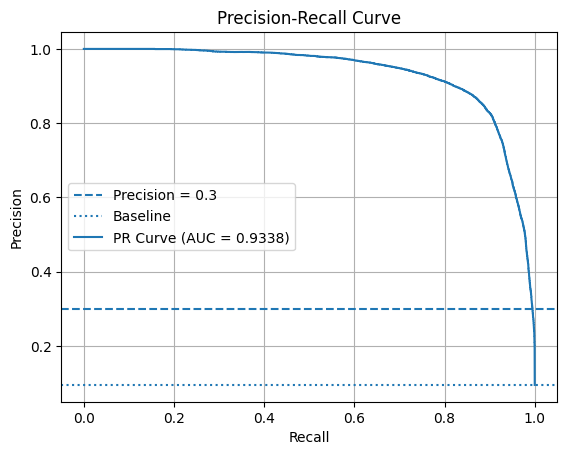

In [45]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# PR 곡선 계산
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# PR-AUC
pr_auc = average_precision_score(y_test, y_proba)


# 시각화
plt.figure()
plt.axhline(y=0.3, linestyle="--", label="Precision = 0.3")

baseline = y_test.mean()
plt.axhline(y=baseline, linestyle=":", label="Baseline")

plt.plot(recall, precision, label=f"PR Curve (AUC = {pr_auc:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()


In [47]:
from sklearn.metrics import (
    precision_score, recall_score,
    precision_recall_curve
)

y_proba = cb_model.predict_proba(X_test_cb)[:, 1]
y_true = y_test.values

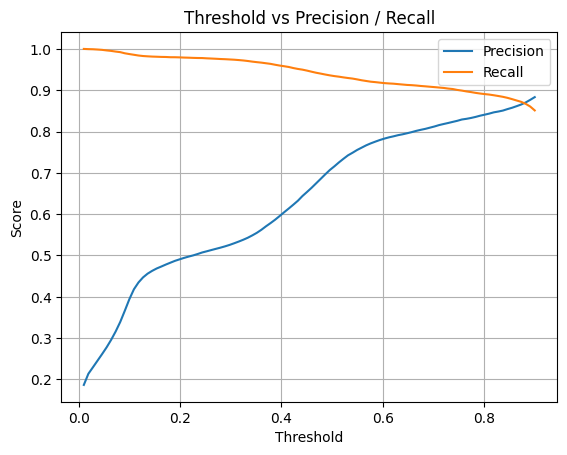

In [48]:
thresholds = np.linspace(0.01, 0.9, 100)

precisions, recalls = [], []

for t in thresholds:
    y_pred = (y_proba >= t).astype(int)
    precisions.append(precision_score(y_true, y_pred, zero_division=0))
    recalls.append(recall_score(y_true, y_pred))

plt.figure()
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold vs Precision / Recall")
plt.legend()
plt.grid(True)
plt.show()


# Cumulative Gain / Recall@Top-K 곡선

## 👉 BM 질문에 바로 답 가능

“상위 10% 타겟 시, 이탈의 몇 %를 막을 수 있나?”

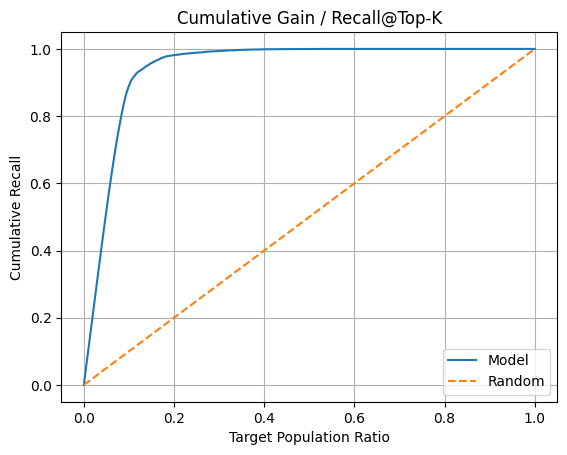

In [49]:
df = pd.DataFrame({
    "y_true": y_true,
    "y_proba": y_proba
}).sort_values("y_proba", ascending=False)

df["cum_recall"] = df["y_true"].cumsum() / df["y_true"].sum()
df["population_ratio"] = np.arange(1, len(df) + 1) / len(df)

plt.figure()
plt.plot(df["population_ratio"], df["cum_recall"], label="Model")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.xlabel("Target Population Ratio")
plt.ylabel("Cumulative Recall")
plt.title("Cumulative Gain / Recall@Top-K")
plt.legend()
plt.grid(True)
plt.show()


# Feature Importance / SHAP

## 각 피처가 “이 샘플의 이탈 확률을 얼마나, 어느 방향으로 밀었는지”를 보는 데이터입니다.

중요도(Importance)
→ 자주, 크게 쓰인 변수인가

SHAP 값
→ 이 변수 때문에 점수가 얼마나 올라갔나 / 내려갔나

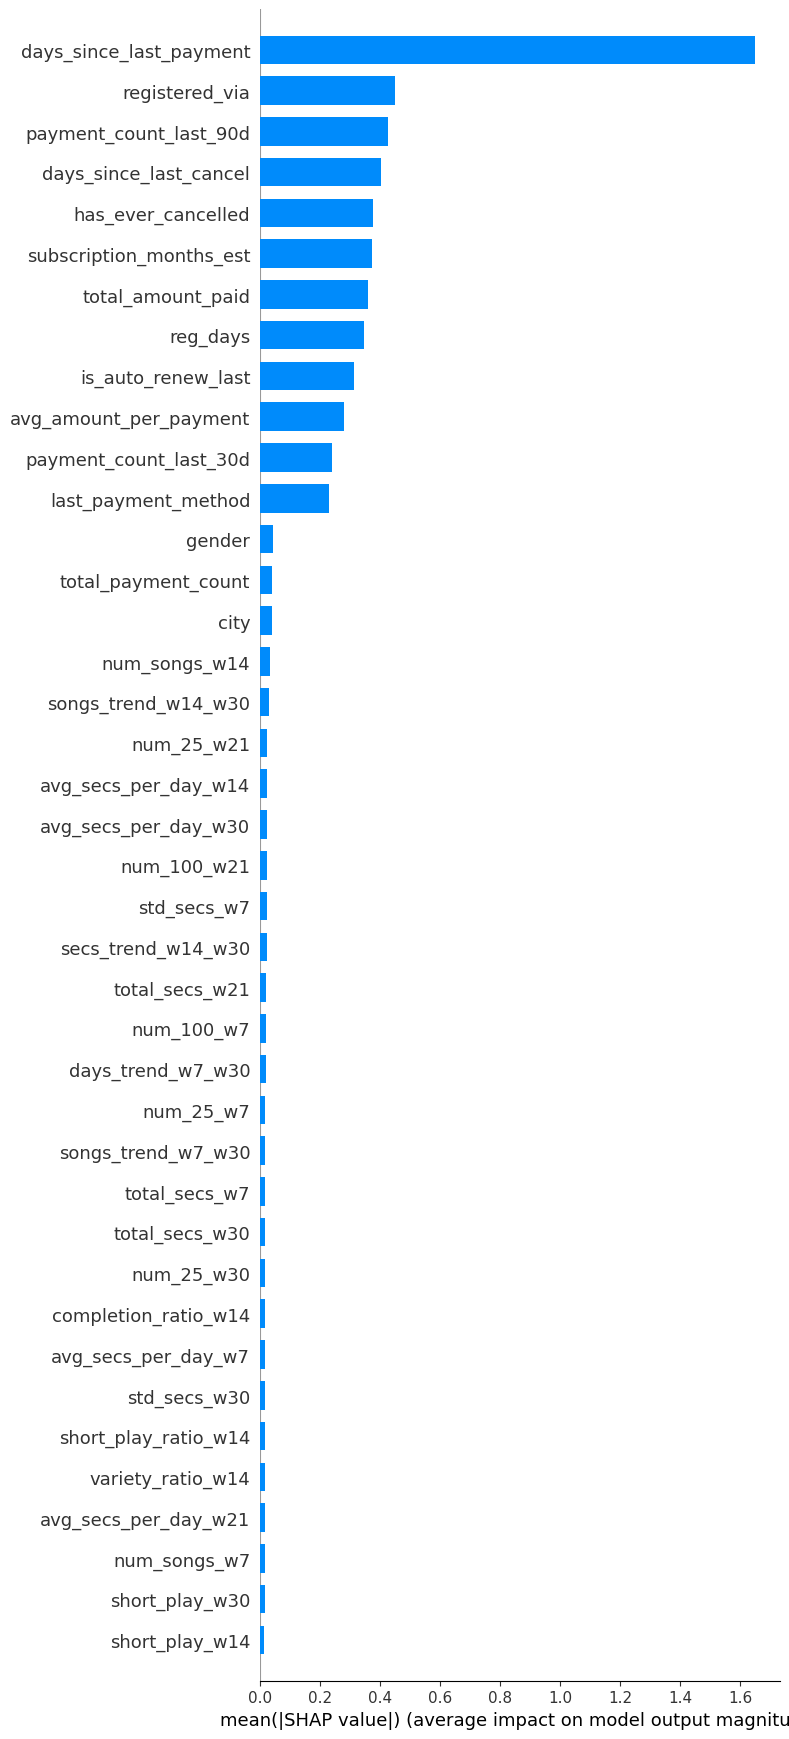

In [39]:
# pip install ipywidgets
# pip install shap
import shap
# from autonotebook import tqdm as notebook_tqdm

explainer = shap.TreeExplainer(cb_model)
shap_values = explainer.shap_values(X_test_cb)

shap.summary_plot(
    shap_values,
    X_test_cb,
    plot_type="bar",
    max_display=40
)


# Cost curve + threshold 최적값
## 최소 비용 threshold + 시각적 표시 + 수치 출력까지 포함한 정석 구현입니다.

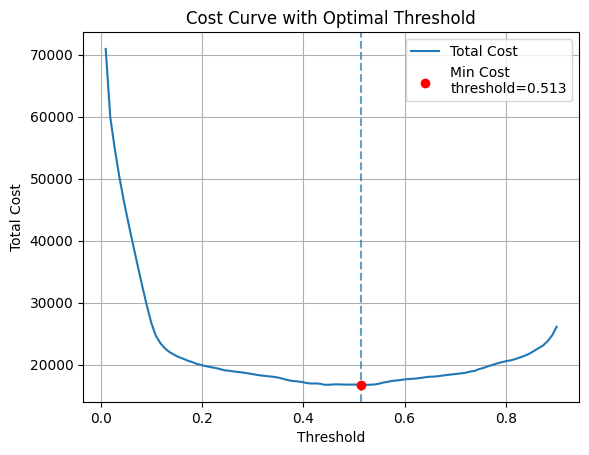

최소 Total Cost: 16719
Optimal Threshold: 0.5134
Precision: 0.7251
Recall: 0.9327


In [38]:
C = 1    # 개입 비용
L = 10   # 이탈 손실

thresholds = np.linspace(0.01, 0.9, 100)
costs = []

for t in thresholds:
    y_pred = (y_proba >= t).astype(int)
    FP = ((y_pred == 1) & (y_true == 0)).sum()
    FN = ((y_pred == 0) & (y_true == 1)).sum()
    costs.append(FP * C + FN * L)

costs = np.array(costs)

# 최소 비용 지점
min_idx = np.argmin(costs)
best_threshold = thresholds[min_idx]
min_cost = costs[min_idx]

plt.figure()
plt.plot(thresholds, costs, label="Total Cost")

# 최저점 표시
plt.scatter(
    best_threshold,
    min_cost,
    color="red",
    zorder=5,
    label=f"Min Cost\nthreshold={best_threshold:.3f}"
)

plt.axvline(best_threshold, linestyle="--", alpha=0.7)
plt.xlabel("Threshold")
plt.ylabel("Total Cost")
plt.title("Cost Curve with Optimal Threshold")
plt.legend()
plt.grid(True)
plt.show()

print(f"최소 Total Cost: {min_cost}")
print(f"Optimal Threshold: {best_threshold:.4f}")

# 해당 threshold에서의 성능
y_pred_opt = (y_proba >= best_threshold).astype(int)

print(f"Precision: {precision_score(y_true, y_pred_opt):.4f}")
print(f"Recall: {recall_score(y_true, y_pred_opt):.4f}")


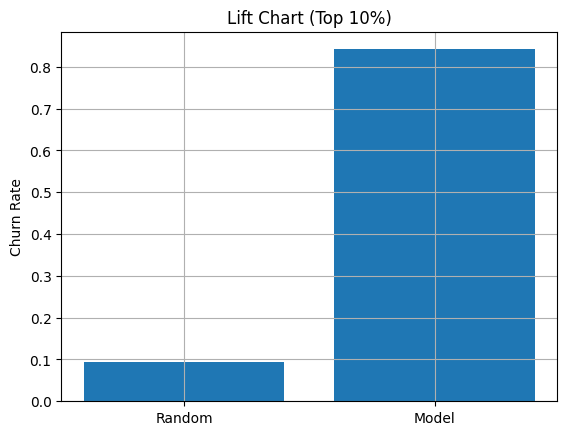

In [33]:
top_k = 0.1  # 상위 10%

cut = int(len(df) * top_k)
model_lift = df.iloc[:cut]["y_true"].mean()
random_lift = df["y_true"].mean()

plt.figure()
plt.bar(["Random", "Model"], [random_lift, model_lift])
plt.ylabel("Churn Rate")
plt.title("Lift Chart (Top 10%)")
plt.grid(True)
plt.show()


# 타겟 규모 vs 성과 시각화

목적

예산 변화에 따른 성과 시뮬레이션

👉 BM 활용

“예산을 2배 쓰면 Recall이 얼마나 오르나?”

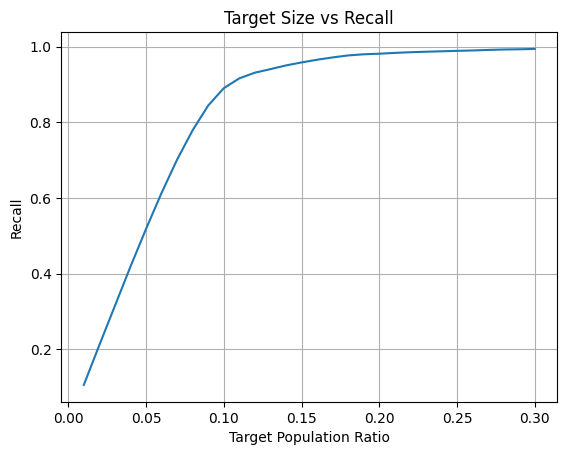

In [34]:
target_ratios = np.linspace(0.01, 0.3, 30)
recalls = []

for r in target_ratios:
    cut = int(len(df) * r)
    recalls.append(df.iloc[:cut]["y_true"].sum() / df["y_true"].sum())

plt.figure()
plt.plot(target_ratios, recalls)
plt.xlabel("Target Population Ratio")
plt.ylabel("Recall")
plt.title("Target Size vs Recall")
plt.grid(True)
plt.show()
